# Individual household electric power consumption for Deep Learning Workshop

---


This notebook is the second assignment in the deep learning workshop course in ben gurion university of the negev. It's purpose is to use machine and deep learning for time-sereis analysis.

we chose to work on the Individual household electric power consumption from UCI.
which can be read more here: https://archive.ics.uci.edu/ml/datasets/individual+household+electric+power+consumption

The note book follows these steps:

1. Explantion and EDA of the dataset with some visualization. and our problem definition.
2. Creating a naive baseline for the problem.
3. Building a machine learning model to solve the problem
4. Building ANN model for time-series analysis.

Using colab and google drive - mount the drive to the notebook.

In [0]:
from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive/


Imports for all the sections of the notebook. one may choose to divide those but we like it better in one place.

In [0]:
import os
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

import keras
from keras.layers import Dense, LSTM, Conv1D, MaxPooling1D,Dropout
from keras.models import Sequential
from keras.utils import to_categorical
from keras.optimizers import SGD 
from keras.callbacks import EarlyStopping
from keras.utils import np_utils
import itertools


Using TensorFlow backend.


# 1. EDA: Exploratory Data Analysis and problem definition
in this part we explore the  dataset with some visualization.
the first part of any data science project is to get to know your data.

The Household Power Consumption dataset is a multivariate time series dataset that describes the electricity consumption for a single household over four years.

In [0]:

tal_path = 'drive/My Drive/MY DLWS/household_power_consumption.txt'
doron_path = 'drive/My Drive/DLWS/Assignment2/household_power_consumption.txt'

path_to_file = tal_path
df = pd.read_csv(path_to_file,sep=';')



/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (2,3,4,5,6,7) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


we load the data and have a first look at it.

In [0]:
print(df.head())
print(df.shape)


         Date      Time Global_active_power Global_reactive_power  Voltage  \
0  16/12/2006  17:24:00               4.216                 0.418  234.840   
1  16/12/2006  17:25:00               5.360                 0.436  233.630   
2  16/12/2006  17:26:00               5.374                 0.498  233.290   
3  16/12/2006  17:27:00               5.388                 0.502  233.740   
4  16/12/2006  17:28:00               3.666                 0.528  235.680   

  Global_intensity Sub_metering_1 Sub_metering_2  Sub_metering_3  
0           18.400          0.000          1.000            17.0  
1           23.000          0.000          1.000            16.0  
2           23.000          0.000          2.000            17.0  
3           23.000          0.000          1.000            17.0  
4           15.800          0.000          1.000            17.0  
(2075259, 9)


the date set has 2075259 samples, each of them are measurements gathered in a house located in Sceaux (7km of Paris, France) between December 2006 and November 2010 (47 months) each minute. 
It is a multivariate series comprised of 7 variables (besides the date and time) as we can see 
they are:

* global_active_power: The total active power consumed by the household (kilowatts).
* global_reactive_power: The total reactive power consumed by the household (kilowatts).
* voltage: Average voltage (volts).
* global_intensity: Average current intensity (amps).
* sub_metering_1: Active energy for kitchen (watt-hours of active energy).
* sub_metering_2: Active energy for laundry (watt-hours of active energy).
* sub_metering_3: Active energy for climate control systems (watt-hours of active energy).

the dataset is said to have missing values and from a quick look at it we can see they are sometime 'na' and sometime '?'.
so what we are doing is to load the data again only this time we will treat both of the above as missing values and combine the date with the time and use it as index to form the time-series problem.




In [0]:
df = pd.read_csv(path_to_file,sep=';',na_values=['nan','?'],infer_datetime_format=True,parse_dates={'date_time':['Date','Time']},index_col='date_time')


Let's look at the data now and check how many mising values are there and what is the type of each feature.

In [0]:
print(df.head())
print('the types of the features are:' )
print(df.dtypes)
print('the shape of the data is' )
print(df.shape)
print('how many missing values are there per feature')
print(df.isna().sum())
print('total number of missing values')
print(df.isna().sum().sum())

                     Global_active_power  Global_reactive_power  Voltage  \
date_time                                                                  
2006-12-16 17:24:00                4.216                  0.418   234.84   
2006-12-16 17:25:00                5.360                  0.436   233.63   
2006-12-16 17:26:00                5.374                  0.498   233.29   
2006-12-16 17:27:00                5.388                  0.502   233.74   
2006-12-16 17:28:00                3.666                  0.528   235.68   

                     Global_intensity  Sub_metering_1  Sub_metering_2  \
date_time                                                               
2006-12-16 17:24:00              18.4             0.0             1.0   
2006-12-16 17:25:00              23.0             0.0             1.0   
2006-12-16 17:26:00              23.0             0.0             2.0   
2006-12-16 17:27:00              23.0             0.0             1.0   
2006-12-16 17:28:00          

So, all the categories are of the same type, that's easy and we can see that for each feature there is the exact number of missing values, from that and looking at the data we can say that there are some records in which there are no feautres. must have been somthing wrong with the measurment equipment that minute.

We will fill al the missing values with mean of the feature. it's a reasonable assumption and we saw most people do it while working on this dataset.


In [0]:
df = df.fillna(df.mean())

In [0]:
print(df.isnull().sum())
print(df.isnull().sum().sum())

Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
dtype: int64
0


Now that we have basic understanig of what the data is and there are no missing values let's begin the actuacl EDA.
first we will look at 4 main features resample over a day

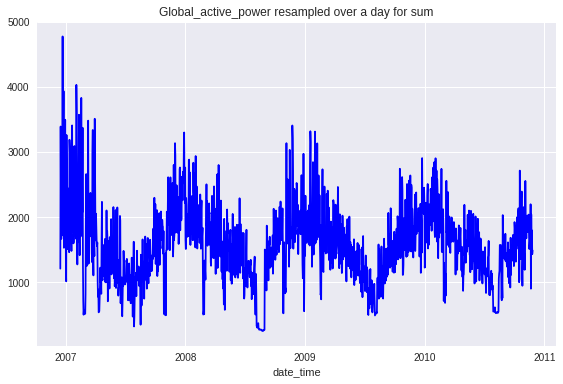

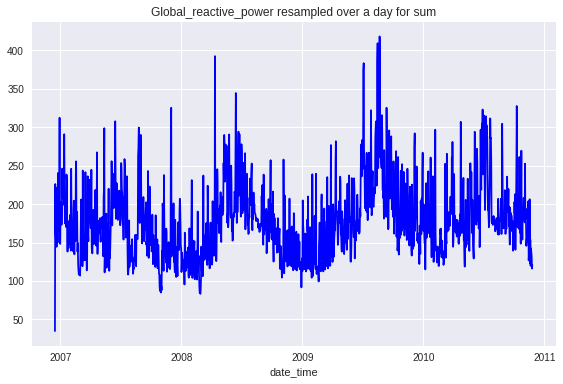

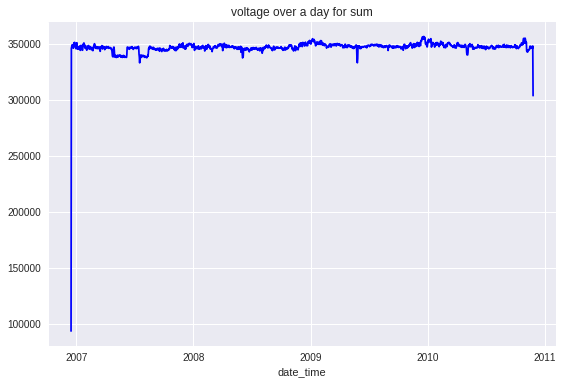

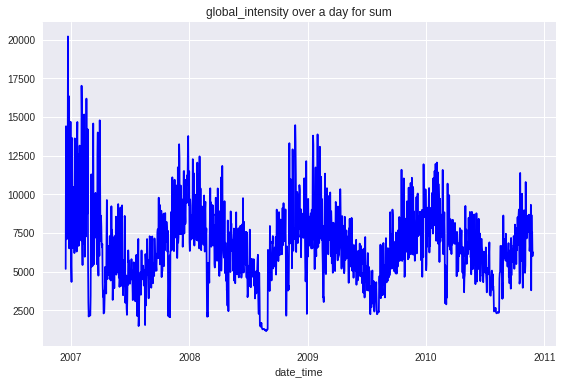

In [0]:
df.Global_active_power.resample('D').sum().plot(title='Global_active_power resampled over a day for sum',color='blue') 
plt.tight_layout()
plt.show() 

df.Global_reactive_power.resample('D').sum().plot(title='Global_reactive_power resampled over a day for sum',color='blue') 
plt.tight_layout()
plt.show() 


df.Voltage.resample('D').sum().plot(title='voltage over a day for sum',color='blue') 
plt.tight_layout()
plt.show()   


df.Global_intensity.resample('D').sum().plot(title='global_intensity over a day for sum',color='blue') 
plt.tight_layout()
plt.show() 


And over a period of weeks

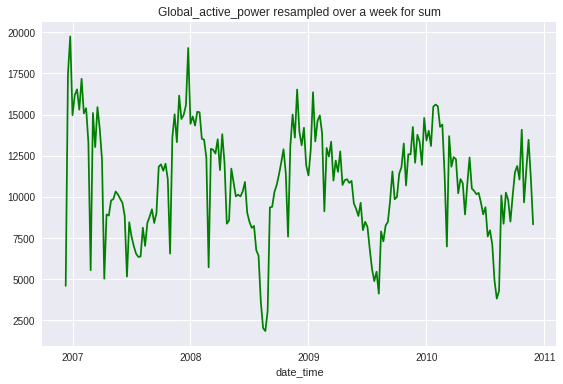

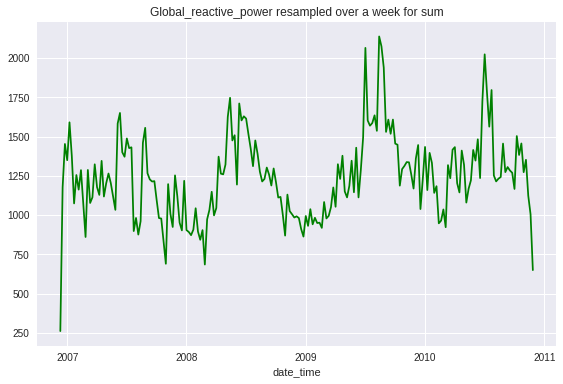

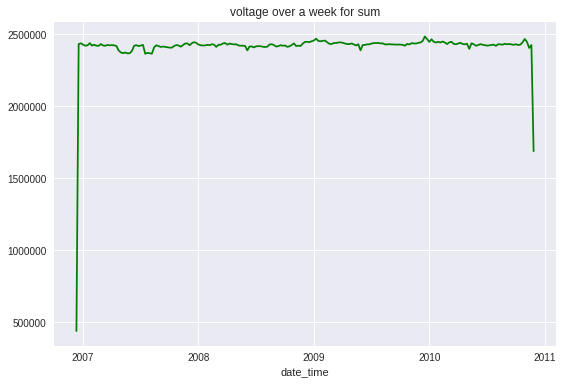

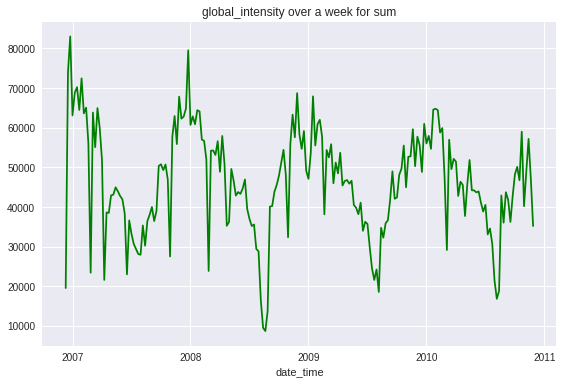

In [0]:
df.Global_active_power.resample('W').sum().plot(title='Global_active_power resampled over a week for sum',color='green') 
plt.tight_layout()
plt.show() 

df.Global_reactive_power.resample('W').sum().plot(title='Global_reactive_power resampled over a week for sum',color='green') 
plt.tight_layout()
plt.show() 

df.Voltage.resample('W').sum().plot(title='voltage over a week for sum',color='green') 
plt.tight_layout()
plt.show()   


df.Global_intensity.resample('W').sum().plot(title='global_intensity over a week for sum',color='green') 
plt.tight_layout()
plt.show() 


We can see volatge behave very differnet than the others. and according to the dataset is measured in a differnt way. so probably moving ahead we wont use it as much..
let's see the feautres over a week on the same graph.

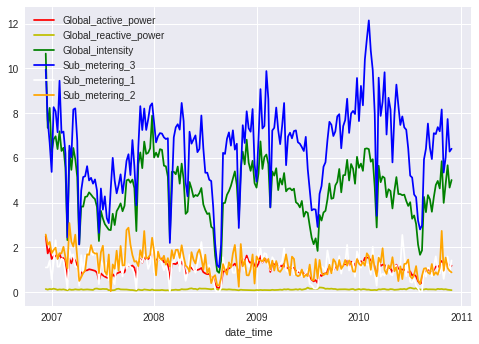

In [0]:
# voltage measured differntly, therefore is not shown here 
df.Global_active_power.resample('W').mean().plot(color='r', legend=True)
df.Global_reactive_power.resample('W').mean().plot(color='y', legend=True)
df.Global_intensity.resample('W').mean().plot(color='g', legend=True)
df.Sub_metering_3.resample('W').mean().plot(color='b', legend=True)
df.Sub_metering_1.resample('W').mean().plot(color='w', legend=True)
df.Sub_metering_2.resample('W').mean().plot(color='orange', legend=True)
plt.show()

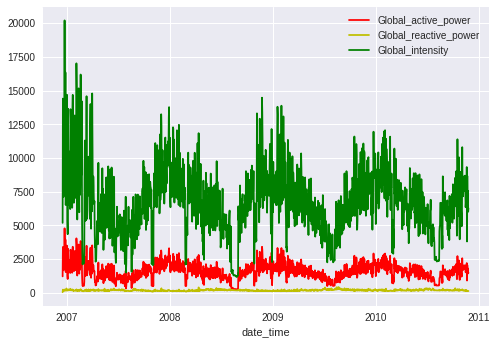

In [0]:
df.Global_active_power.resample('D').sum().plot(color='r', legend=True)
df.Global_reactive_power.resample('D').sum().plot(color='y', legend=True)
df.Global_intensity.resample('D').sum().plot(color='g', legend=True)
plt.show()

Let's check the corrleation between the features over a week.

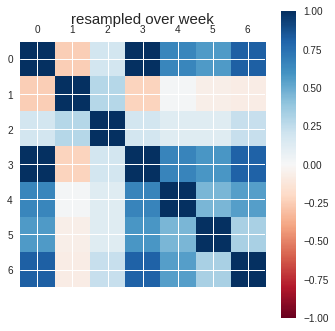

In [0]:
plt.matshow(df.resample('W').sum().corr(method='pearson'),vmax=1,vmin=-1,cmap='RdBu')
plt.title('resampled over week', size=15)
plt.colorbar()
plt.show()

And over a day

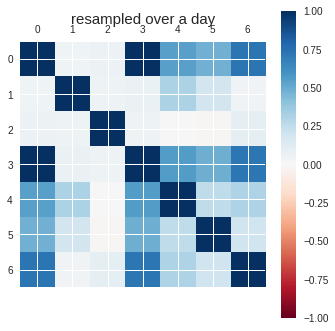

In [0]:
plt.matshow(df.resample('D').sum().corr(method='pearson'),vmax=1,vmin=-1,cmap='RdBu')
plt.title('resampled over a day', size=15)
plt.colorbar()
plt.show()

As suspected, voltage is not coralated to most features over a weekly and daily bases.
global active power is corralted to most featues as can be expected and each sub metring is somewhat coroolated to the others.

We can investigate the distributions of the data by reviewing histograms.

We can see that active and reactive power, intensity, as well as the sub-metered power are all skewed distributions downand that the distribution of voltage data is strongly Gaussian.

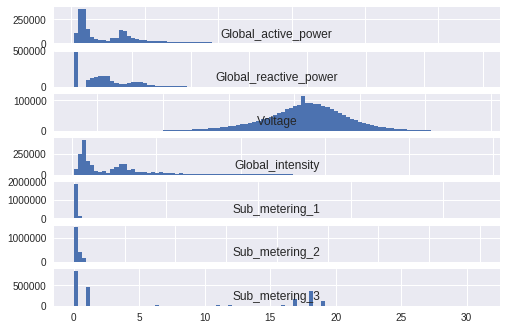

In [0]:
plt.figure()
for i in range(len(df.columns)):
	plt.subplot(len(df.columns), 1, i+1)
	name = df.columns[i]
	df[name].hist(bins=100)
	plt.title(name, y=0)
plt.show()

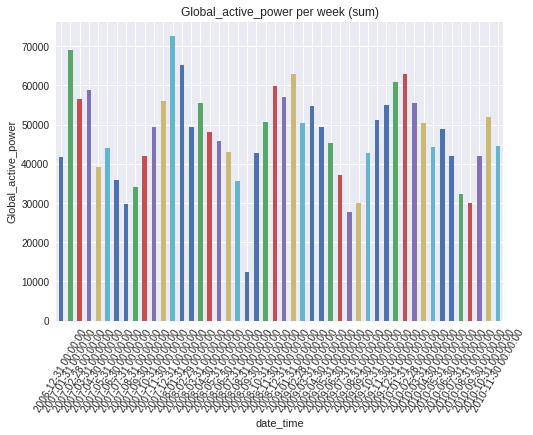

In [0]:
df['Global_active_power'].resample('M').sum().plot(kind='bar')
plt.xticks(rotation=60)
plt.ylabel('Global_active_power')
plt.title('Global_active_power per week (sum)')
plt.show()

So, we finish the EDA part. of course there are many more thing that can be done and new 'views' to look at the data to explore but for the purpose of this notebook we find that's enough.

# Problem descripition and navie soultion

There are many ways to explore the household power consumption dataset.
here we decided to use the data to explore a very specific question which is :
"Given recent power consumption, what is the expected power consumption for the week ahead?"

This requires that a predictive model forecast the total active power for each day over the next seven days.
as we learned from the all mighty internet this framing of the problem is referred to as a multi-step time series forecasting problem, given the multiple forecast steps.

A problem  this type could be helpful within the household in planning expenditures. 

also the framing of the proble according to our eda shows that it would be useful to downsample the per-minute observations of power consumption to daily totals. 


In [0]:
daily_data = df.resample('D').sum()
print(daily_data.shape)
print(daily_data.head())

(1442, 7)
            Global_active_power  Global_reactive_power    Voltage  \
date_time                                                           
2006-12-16             1209.176                 34.922   93552.53   
2006-12-17             3390.460                226.006  345725.32   
2006-12-18             2203.826                161.792  347373.64   
2006-12-19             1666.194                150.942  348479.01   
2006-12-20             2225.748                160.998  348923.61   

            Global_intensity  Sub_metering_1  Sub_metering_2  Sub_metering_3  
date_time                                                                     
2006-12-16            5180.8             0.0           546.0          4926.0  
2006-12-17           14398.6          2033.0          4187.0         13341.0  
2006-12-18            9247.2          1063.0          2621.0         14018.0  
2006-12-19            7094.0           839.0          7602.0          6197.0  
2006-12-20            9313.0    

from our problem description we will want to train and test ourselves on a weekly bases, that's the purpose of the function

In [0]:
def dataframe_weekly_split(data):
  train, test = data.values[1:-328], data.values[-328:-6]
  train = np.array(np.split(train,len(train)/7))
  test = np.array(np.split(test,len(test)/7))
  return train, test


our naive soultion: 
naive forecast when forecasting a standard week is to use the entire prior week as the forecast for the week ahead.

It is based on the idea that next week will be very similar to this week.

Evaluation:
A forecast will be comprised of seven values, one for each day of the week ahead.

The units of the total power are kilowatts and it would be useful to have an error metric that was also in the same unit.  we will use Root Mean Squared Error (RMSE)

The performance metric for this problem will be the RMSE for each lead time from day 1 to day 7.
and score will be RMSE across all forecast days.

Models will be evaluated using a scheme called walk-forward validation which we saw online that fit time series analysis.

This is where a model is required to make a one week prediction, then the actual data for that week is made available to the model so that it can be used as the basis for making a prediction on the subsequent week. This is both realistic for how the model may be used in practice and beneficial to the models allowing them to make use of the best available data.

In [0]:
#naive baseline
train, test = dataframe_weekly_split(daily_data)
history = [x for x in train]
predictions = []
for i in range(len(test)):
  pred = history[-1][:,0]
  predictions.append(pred)
  history.append(test[i,:])
predictions = np.array(predictions)
rmse = np.sqrt(np.mean((predictions-test[:,:,0])**2))
print(rmse)
  


480.80634340518833


We can see we got a RMSE score of 480 which is not bad for this kind of problem defintion and is consistnet with other result we saw online.

# **Machine Learning Model**
Most predictive modeling algorithms will take some number of observations as input and predict a single output value. so  we cant use them directly to make a multi-step time series forecast like our problem.

what we wil do is use a recursive approch for that:

This involves making a prediction for one time step, taking the prediction, and feeding it into the model as an input in order to predict the subsequent time step. 

The first step is to convert the prepared training data in window format into a single univariate series using the to_series function.



In [0]:
def to_series(data,features=None):
  """Transform the data into a series, taking into account the features we decide"""
  if features==None:
    series_data = [week[:,0] for week in data]
  else:
    series_data = [week[:, features] for week in data]
  return np.array(series_data).flatten()

Next, the sequence of daily power needs to be transformed into inputs and outputs suitable for fitting a supervised learning problem.

The prediction will be some function of the total power consumed on prior days. There will always be a single output: the total power consumed on the next day.

The model will be fit on the true observations from prior time steps. We need to iterate through the sequence of daily features and split it into inputs and outputs. you can see the function next. it's basically a sliding window.



In [0]:
#check for window 
def supervised_transformation(history,n_samples=7,features=[0]):
  """history is all the data we have so far in the window, n_samples is the number of days to look back at
  features is a list of the features to use"""
  window = n_samples*len(features)
  data = to_series(history,features)
  x_train, y_train = [],[]
  i_start = 0
  for _ in range(len(data)):
    i_end = i_start + window
    if i_end < len(data):
      x_train.append(data[i_start:i_end])
      y_train.append(data[i_end])
    i_start += len(features)
  return np.array(x_train),np.array(y_train)

To create predictions we used the Lasso ml algortihm, and did a very simillar procees to what we did in the naive approch, that is walk forward validation. when the sliding window is the size of the days to look back at times the number of features we want to see in each day.

In [0]:
def model_predict(history, n_samples=7,features=[0]):
  window = n_samples*len(features)
  model = Lasso()
  x_train, y_train = supervised_transformation(history,n_samples,features)
  scaler = StandardScaler()
  scaler.fit(x_train)
  model = model.fit(x_train,y_train)
  input_data = list(x_train[-1,:])
  predictions = []
  for j in range(n_samples):
    X = np.array(input_data[-window:]).reshape(1,window)
    pred = model.predict(X)[0]
    predictions.append(pred)
    input_data.append(pred)
  return predictions
    
  
  

In [0]:
def evaulate_power(data,n_samples=7,features=[0]):
  train, test = dataframe_weekly_split(data)
  history = [x for x in train]
  predictions = []
  for i in range(len(test)):
    pred = model_predict(history,7,features)
    predictions.append(pred)
    history.append(test[i,:])
  predictions = np.array(predictions)
  rmse = np.sqrt(np.mean((predictions-test[:,:,0])**2))
  print(rmse)

We ran the model seveal times:

In [0]:
evaulate_power(daily_data)
evaulate_power(daily_data,n_samples=7,features=[0,1])
evaulate_power(daily_data,n_samples=7,features=[0,1,4])


397.0166712875381
2329.7493935154394
2037.7465152226368


We can see that when using only the active_power feature to predict as we did in the naive model we get a better result than the naive model.
we can also see that when intrducing more features to try and predict with them the RMSE score goes up, so other features are hurting our pedictions in the time series when use as is.

# **Deep Learning Model**
In this part we will use LSTM to solve the same problem as before.
Recurrent neural networks, or RNNs, are specifically designed to work, learn, and predict sequence data.

In [0]:
train, test = dataframe_weekly_split(daily_data)

 as we saw in class, LSTM model expects data to have the shape:
[samples, timesteps, features]
sample will be comprised of seven time steps with a number of features for the seven days of total daily power consumed.

The training dataset has 159 weeks of data, so the shape of the training dataset would be:
[159,7,number of features]

The data in this format would use the prior standard week to predict the next standard week. A problem is that 159 instances is not a lot.

A way to create a lot more training data is to change the problem during training to predict the next seven days given the prior seven days, regardless of the standard week.

This only impacts the training data, and the test problem remains the same: predict the daily power consumption for the next standard week given the prior standard week.

This will require flatting of the data as shown in the first line of the function

In [0]:
def supervised_transformation(train ,n_samples=7,features=[0]):
  data = train.reshape((train.shape[0]*train.shape[1], train.shape[2]))
  x, y = [], []
  in_start = 0
  for _ in range(data.shape[0]):
    in_end = in_start + n_samples
    out_end = in_end + 7
    if out_end < data.shape[0]:
      x_input = data[in_start:in_end, features]
      x_input = x_input.reshape((len(x_input)), len(features))
      x.append(x_input)
      y.append(data[in_end:out_end, 0])
    in_start += 1
  return np.array(x), np.array(y)

This will require flatting of the data, next we train and fit our model using n_samples - the days to look back each time and a list of features to use. using the above function to transform the problem into a supervised robust problem.

In [0]:
n_samples = 7
features = [0]


x_train, y_train = supervised_transformation(train, n_samples, features)
x_test, y_test = supervised_transformation(test, n_samples, features)
n_timesteps, n_features, n_outputs = x_train.shape[1], x_train.shape[2], y_train.shape[1]


Note we build our very basic ANN model. and fit it on the data.

In [0]:
model = Sequential()
model.add(LSTM(200, activation='relu', input_shape=(n_timesteps, n_features)))
model.add(Dense(100, activation='relu'))
model.add(Dense(n_outputs))
model.compile(loss='mse', optimizer='adam')
print(model.summary())
history = model.fit(x_train, y_train, epochs=1000, batch_size=128)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 200)               161600    
_________________________________________________________________
dense_1 (Dense)              (None, 100)               20100     
_________________________________________________________________
dense_2 (Dense)              (None, 7)                 707       
Total params: 182,407
Trainable params: 182,407
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/1000
1099/1099 [==============================] - 1s 1ms/step - loss: 2895800.1870
Epoch 2/1000
1099/1099 [==============================] - 0s 346us/step - loss: 2345219.4790
Epoch 3/1000
1099/1099 [==============================] - 0s 378us/step - loss: 1052917.0062
Epoch 4/1000
1099/1099 [==============================] - 0s 353us/step - loss: 365011.4251
Epoch 5/1000
1099/1099 [==

Lets look at our loss function over time.

In [0]:
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


next we use walk forwas validation to test the model on the test set

In [0]:
def forecast(model, history, n_samples, features):
  data = np.array(history)
  data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))
  input_x = data[-n_samples:,features].reshape(1,n_samples,len(features))
  pred = model.predict(input_x)
  return pred[0]


history = [x for x in train]
# walk-forward validation over each week
predictions = []
for i in range(len(test)):
	# predict the week
	yhat_sequence = forecast(model, history, n_samples, features)
	# store the predictions
	predictions.append(yhat_sequence)
	# get real observation and add to history for predicting the next week
	history.append(test[i, :])
  
predictions = np.array(predictions)


mean_squared_error(test[:,:,0], predictions)**0.5

In [0]:
predictions[0][0]

In [0]:
aa=[x for x in range(7)]
plt.plot([1,2,3,4,5,6,7], test[:,:,0] , marker='.', label="actual")
plt.plot([1,2,3,4,5,6,7], predictions, 'r', label="prediction")
plt.ylabel('Global_active_power', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show()

We can see the model trained only on the active power feature did better then the other approchecs using the same feature and gave the best result overall and it better at handling more features.

Thanks fo reading, for any problem you may contact tal ben-senior at talbnse@post.bgu.ac.il